In [1]:
import pandas as pd
import numpy as np
import json
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load Configuration
def load_config(config_path):
    with open(config_path, "r") as file:
        return json.load(file)

# Load and Preprocess Data
def preprocess_data(data_path, groupby_columns=None):
    df = pd.read_csv(data_path)
    
    if groupby_columns:
        group_columns = groupby_columns
        df["DATE"] = pd.to_datetime(df["YEAR"].astype(str) + "-" + df["MONTH"].astype(str) + "-01") + pd.offsets.MonthEnd(0)
        df.sort_values("DATE", inplace=True)
        df = df.groupby(group_columns)
        return df
    else:
        df["DATE"] = pd.to_datetime(df["YEAR"].astype(str) + "-" + df["MONTH"].astype(str) + "-01") + pd.offsets.MonthEnd(0)
        df.sort_values("DATE", inplace=True)
        df.dropna(inplace=True)
        return df

# Anomaly Detection
def detect_anomaly(df, kpi_column, threshold):
    anomalies = df.groupby(["YEAR", "MONTH"])[kpi_column].sum().reset_index()
    anomalies = anomalies[anomalies[kpi_column] > threshold]
    return anomalies[["YEAR", "MONTH"]].values.tolist()

# Reverse Label Encoding
def reverse_label_encoding(value, le):
    return le.inverse_transform([value])[0] if le else value

# Perform Diagnostic Analysis
def diagnostic_analysis(df, kpi_column, feature_columns, config, groupby_columns=None):
    threshold = config["kpi_threshold"]
    
    # Detect latest anomaly period
    anomalies = detect_anomaly(df, kpi_column, threshold)
    if not anomalies:
        return "No anomalies detected."
    
    latest_anomaly = anomalies[-1]
    year, month = latest_anomaly
    df_subset = df[(df["YEAR"] == year) & (df["MONTH"] == month)]
    
    # Label encode categorical features
    label_encoders = {}
    for col in feature_columns:
        le = LabelEncoder()
        df_subset[col] = le.fit_transform(df_subset[col])
        label_encoders[col] = le
    
    # Prepare data for SHAP analysis
    X = df_subset[feature_columns]
    y = df_subset[kpi_column]
    
    model = RandomForestRegressor()
    model.fit(X, y)
    predictions = model.predict(X)
    
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    
    # Plot SHAP summary plot
    plt.figure(figsize=(10, 5))
    shap.summary_plot(shap_values, X)
    
    # Identify top contributing factors
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    top_features = np.argsort(feature_importance)[-3:][::-1]
    
    results = {"Anomaly Period": {"Year": year, "Month": month}}
    
    for i, feature_idx in enumerate(top_features):
        feature_name = feature_columns[feature_idx]
        
        # Find top 3 most occurring values in the feature
        top_values = df_subset[feature_name].value_counts().head(3).index.tolist()
        top_kpi_values = {reverse_label_encoding(val, label_encoders.get(feature_name)): df_subset[df_subset[feature_name] == val][kpi_column].sum() for val in top_values}
        results[f"Top Contributing Factor {i+1}"] = {"Feature": feature_name, "Values": top_kpi_values}
        
        subset_df = df_subset[df_subset[feature_name] == top_values[0]]
        X_subset = subset_df[feature_columns]
        y_subset = subset_df[kpi_column]
        
        model_subset = RandomForestRegressor()
        model_subset.fit(X_subset, y_subset)
        explainer_subset = shap.Explainer(model_subset, X_subset)
        shap_values_subset = explainer_subset(X_subset)
        
        feature_importance_subset = np.abs(shap_values_subset.values).sum(axis=0)
        top_sub_feature_idx = np.argsort(feature_importance_subset)[-1]
        top_sub_feature = feature_columns[top_sub_feature_idx]
        
        top_sub_values = subset_df[top_sub_feature].value_counts().head(1).index.tolist()
        top_sub_kpi_value = subset_df[subset_df[top_sub_feature] == top_sub_values[0]][kpi_column].sum()
        
        results[f"Top Contributing Factor {i+1}"][f"Drill Down Top Feature"] = {
            "Feature": top_sub_feature, 
            "Value": reverse_label_encoding(top_sub_values[0], label_encoders.get(top_sub_feature)), 
            "Average KPI": top_sub_kpi_value
        }
    
    return results

# Usage Example:
# config = load_config("config.json")
# df = preprocess_data("/mnt/data/Warehouse_and_Retail_Sales.csv", groupby_columns=["SUPPLIER"])
# result = diagnostic_analysis(df, "RETAIL SALES", feature_columns=["SUPPLIER", "REGION", "MANAGER"], config=config, groupby_columns=["SUPPLIER"])
# print(result)


In [2]:
config = load_config("config.json")


/var/folders/m2/clmfh8k51cgft_j6ybmnn_j00000gn/T/ipykernel_50365/4272877923.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[col] = le.fit_transform(df_subset[col])
/var/folders/m2/clmfh8k51cgft_j6ybmnn_j00000gn/T/ipykernel_50365/4272877923.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset[col] = le.fit_transform(df_subset[col])
/var/folders/m2/clmfh8k51cgft_j6ybmnn_j00000gn/T/ipykernel_50365/4272877923.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

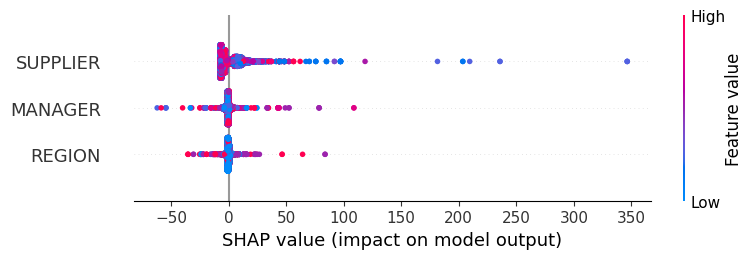

100%|===================| 7270/7271 [00:29<00:00]        

{'Anomaly Period': {'Year': 2020, 'Month': 9},
 'Top Contributing Factor 1': {'Feature': 'SUPPLIER',
  'Values': {'REPUBLIC NATIONAL DISTRIBUTING CO': 771.39,
   'THE COUNTRY VINTNER, LLC DBA WINEBOW': 368.34,
   'SOUTHERN GLAZERS WINE AND SPIRITS': 1866.08},
  'Drill Down Top Feature': {'Feature': 'MANAGER',
   'Value': 'Robert Brown',
   'Average KPI': 229.93}},
 'Top Contributing Factor 2': {'Feature': 'MANAGER',
  'Values': {'Emily White': 14307.09,
   'Jane Smith': 14572.27,
   'Michael Johnson': 17475.65},
  'Drill Down Top Feature': {'Feature': 'SUPPLIER',
   'Value': 'REPUBLIC NATIONAL DISTRIBUTING CO',
   'Average KPI': 112.03}},
 'Top Contributing Factor 3': {'Feature': 'REGION',
  'Values': {'Europe': 51281.44,
   'North America': 20023.04,
   'Oceania': 9338.779999999999},
  'Drill Down Top Feature': {'Feature': 'SUPPLIER',
   'Value': 'THE COUNTRY VINTNER, LLC DBA WINEBOW',
   'Average KPI': 284.74}}}

In [5]:
def main(groupby_columns=None):
    config = load_config("config.json")
    if groupby_columns:
        feature_columns=[col for col in ["SUPPLIER", "REGION", "MANAGER"] if col not in groupby_columns]
    else:
        feature_columns=["SUPPLIER", "REGION", "MANAGER"]
    if not groupby_columns:
        df = preprocess_data("Warehouse_and_Retail_Sales_enhanced.csv")
        result = diagnostic_analysis(df, "RETAIL SALES", feature_columns=feature_columns, config=config)
        return result
    else:
        df_groups = preprocess_data("Warehouse_and_Retail_Sales_enhanced.csv", groupby_columns=groupby_columns)
        results = {}
        for group, df_group in df_groups:
            df_group.dropna(inplace=True)
            result = diagnostic_analysis(df_group, "RETAIL SALES", feature_columns=feature_columns, config=config, groupby_columns=groupby_columns)
            results[group] = result
        return results
    
main()
